In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import stats
import scipy
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10., 10.]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
def plot(X, *args, **kwargs):
    plt.plot(X[0], X[1], '.', ms=1, *args, **kwargs)
    plt.gca().axvline(0, c='grey')
    plt.gca().axhline(0, c='grey')
    plt.gca().set_xlim(-3,3)
    plt.gca().set_ylim(-3,3)
    
def plot_vector(vec1, color='b'): 
    array = np.array([[0, 0, vec1[0], vec1[1]]])
    x, y, u, v = zip(*array)
    ax = plt.gca()
    ax.quiver(x, y, u, v, color=color, angles='xy', scale_units='xy',scale=1)

# Data Transformations

## Data de-correlation

Let's first generate some test data in 2d that are distributed according to a multivariate normal

In [4]:
cov = np.array([[0.07647196, 0.23147416],[0.23147416, 0.98215036]])
X = stats.multivariate_normal([1,1], cov=cov).rvs(10000).T

In [5]:
X

array([[1.58248116, 1.19068507, 0.77386832, ..., 0.93873137, 1.11278742,
        0.76799398],
       [2.64369175, 2.41882216, 0.70868347, ..., 0.51093988, 1.39734613,
        0.25549275]])

In [6]:
X.shape

(2, 10000)

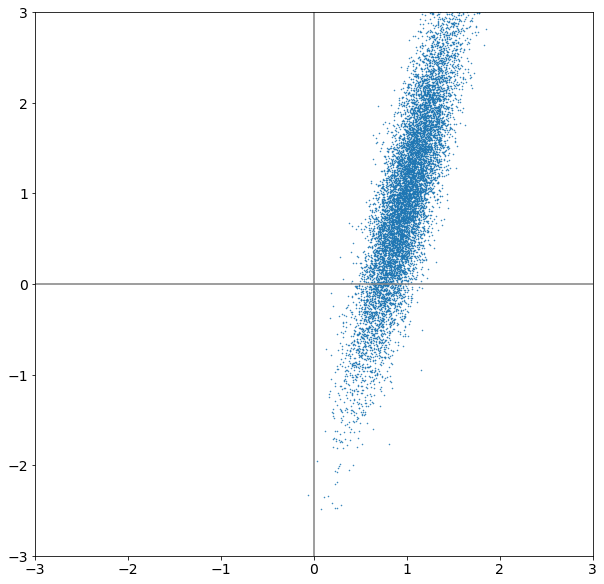

In [7]:
plot(X)

## Subtraction of Mean

In [8]:
X = X - np.mean(X, axis=1)[:, np.newaxis]

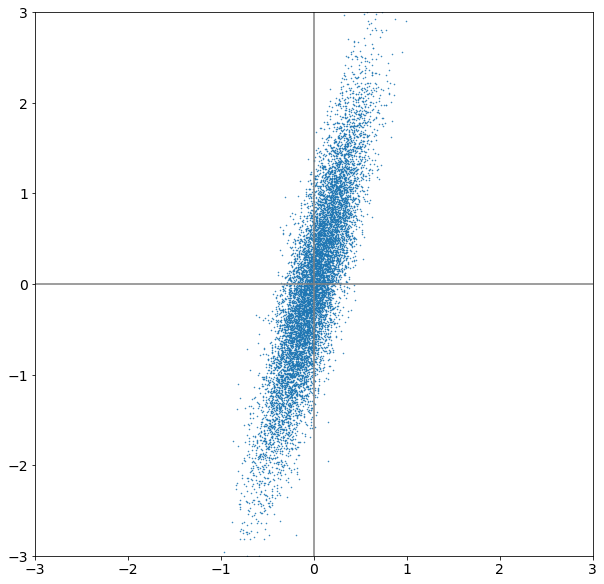

In [9]:
plot(X)

In this space the sample covariance becomes a very simple expressions:


In [10]:
covX = (X @ X.T) / (X.shape[1] - 1) 
covX

array([[0.07517085, 0.22872105],
       [0.22872105, 0.97585039]])

True covariance:

In [11]:
cov

array([[0.07647196, 0.23147416],
       [0.23147416, 0.98215036]])

## Eigenvalue decomposition

We can use scipy's eigenvalue solver to to get the eigenvalues and eigenvectors. Using those we can define our transform `W`

In [12]:
L, E = scipy.linalg.eig(covX)
W = E.T

In [13]:
W

array([[-0.97252178,  0.23281192],
       [-0.23281192, -0.97252178]])

In [14]:
W @ W.T

array([[1.00000000e+00, 1.20475037e-17],
       [1.20475037e-17, 1.00000000e+00]])

The tranformed sample `Y` is now nicely de-correlated

In [15]:
Y = W @ X

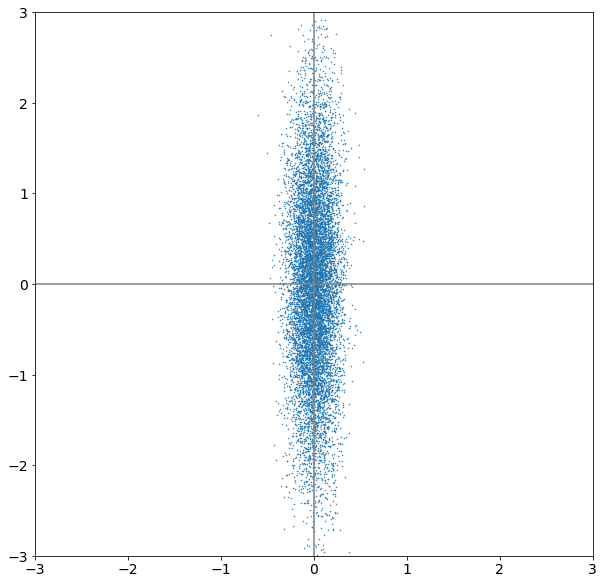

In [16]:
plot(Y)

We can further whiten the sample by sacling with the eigenvalues

In [17]:
s = 1/np.sqrt(L.real)

In [18]:
Y_eigen = (W @ X) * s[:, np.newaxis]

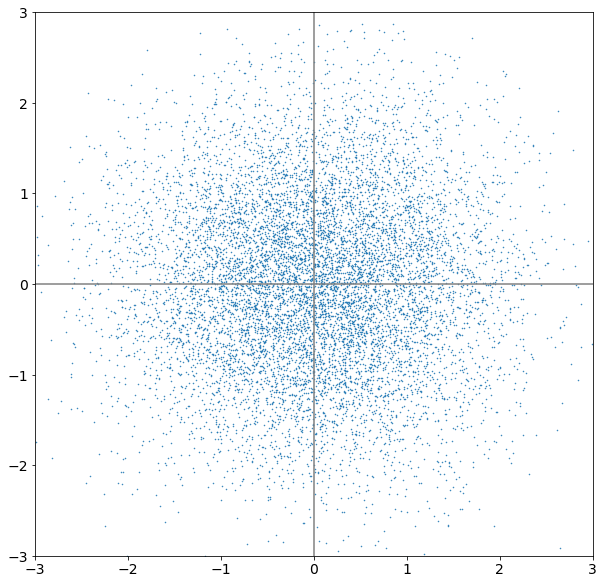

In [20]:
plot(Y_eigen)

The resulting covariance is indeed the identity (up to nummeric imprecisions)

In [21]:
np.cov(Y_eigen)

array([[ 1.00000000e+00, -3.41094623e-17],
       [-3.41094623e-17,  1.00000000e+00]])

# Cholesky

Another way to achieve basically the same is via Cholesky decomposition:

In [22]:
inv_covX = np.linalg.inv(covX)
L = np.linalg.cholesky(inv_covX)
W = L.T

In [23]:
W

array([[ 6.8099863, -1.5961332],
       [ 0.       ,  1.012298 ]])

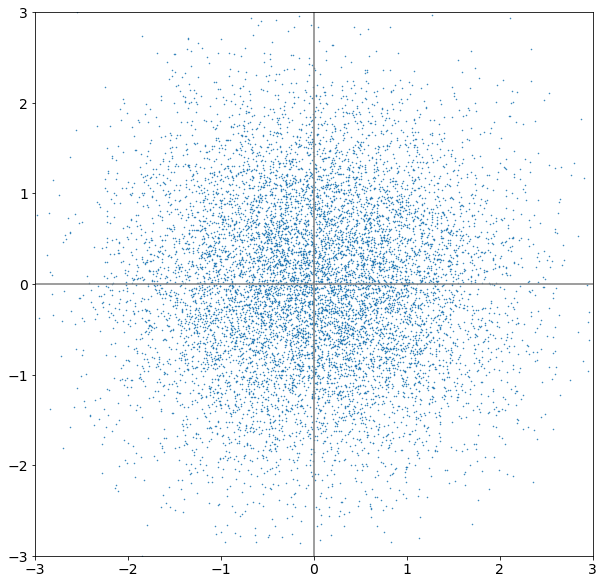

In [24]:
Y_cholesky = W @ X
plot(Y_cholesky)

In [25]:
np.cov(Y_cholesky)

array([[ 1.00000000e+00, -4.26368278e-16],
       [-4.26368278e-16,  1.00000000e+00]])

# SVD

Or via Singular value Decomposition:

In [26]:
U, s, V = np.linalg.svd(X.T)

In [27]:
U.shape

(10000, 10000)

In [28]:
s

array([101.51358741,  14.28820834])

In [29]:
V

array([[-0.23281192, -0.97252178],
       [ 0.97252178, -0.23281192]])

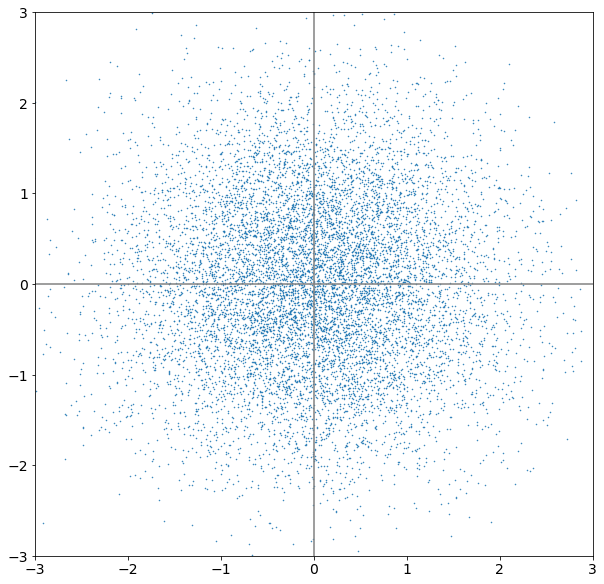

In [30]:
Y_svd = ((V @ X).T @ np.diag(1/s *np.sqrt(X.shape[1] -1))).T
plot(Y_svd)

# Compare

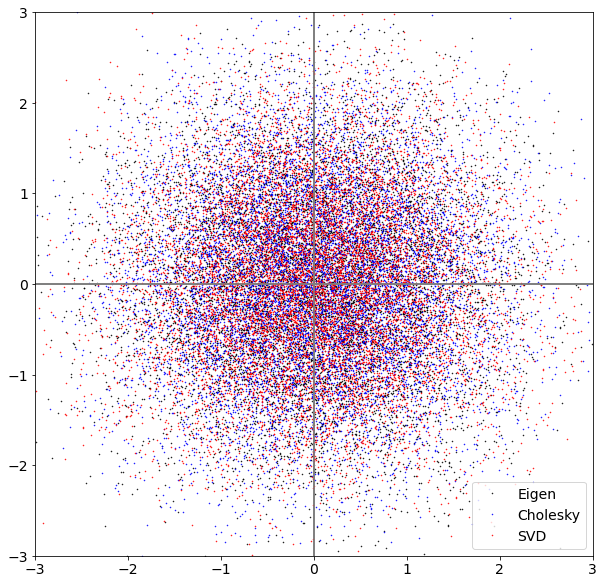

In [31]:
plot(Y_eigen, c='k', label='Eigen')
plot(Y_cholesky, c='b', label='Cholesky')
plot(Y_svd, c='r', label='SVD')
plt.legend()

# Principal Component Analysis

Let's use our SVD to reduce our 2d data to 1d. The component we want to "zero out" is the one with the small variance (the red one in the below plot)

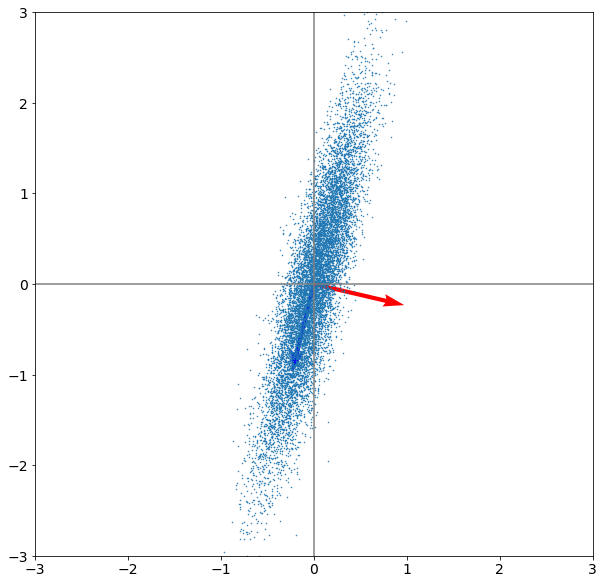

In [32]:
plot(X)
plot_vector(V[0])
plot_vector(V[1], "r")

In [33]:
# just for convenience turn s into a matrix S
S = np.zeros((U.shape[0], V.shape[0]))
np.fill_diagonal(S, s)

In [34]:
# this by the way is the sample covariance
V @ (np.square(S) / (X.shape[1] - 1) @ V.T)[:2]

# and this the recosntructed data X from the SVD
Xrec = (U @ S @ V).T

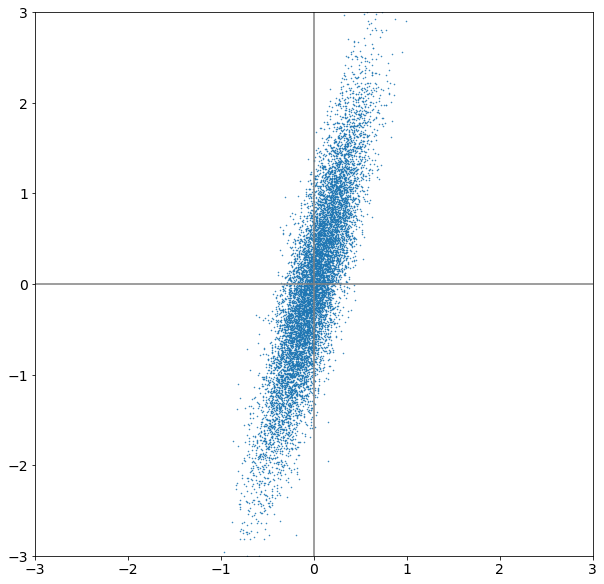

In [35]:
plot(Xrec)

Let us now only use the first component (here indexed with `[0]`), and we can see that we successfully "removed" the small variance. The reconstrcuted sample from the 1d PCA back in the original space now is still 1d, but has most of the information of the original sample

In [36]:
X_pca0 = (U @ S)[:, [0]] @ V[[0]]

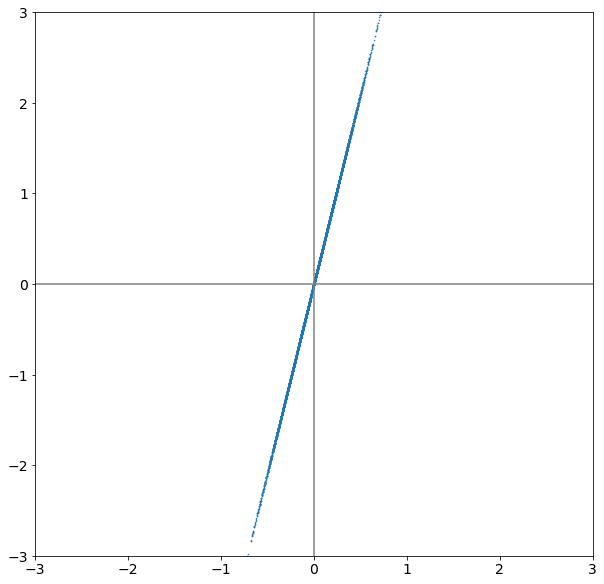

In [37]:
plot(X_pca0.T)

# MNIST PCA

Let's explore the MNSIT dataset and use PCA to reduce its dimensionality

In [38]:
from tools import plot

* standard MNIST:

In [39]:
X = np.load('mnist.npz')['X']

* galaxy MNIST:

In [40]:
#X = np.load('galaxy.npz')['X']

In [41]:
X.shape

(70000, 784)

In [42]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

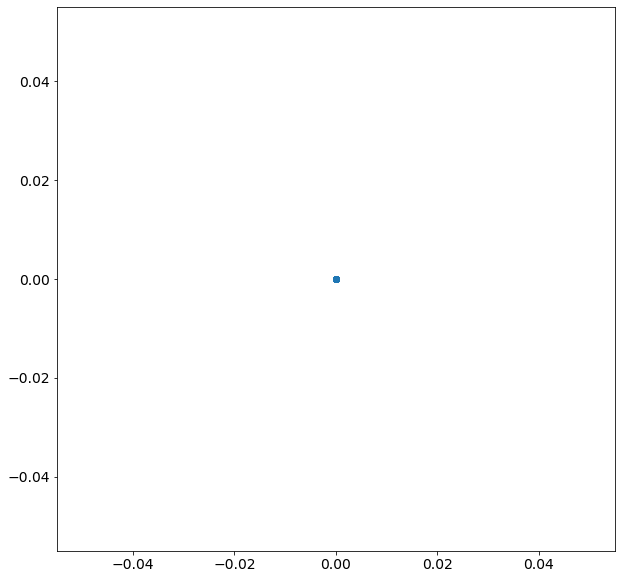

In [43]:
plt.scatter(X[:, 0], X[:, 1])

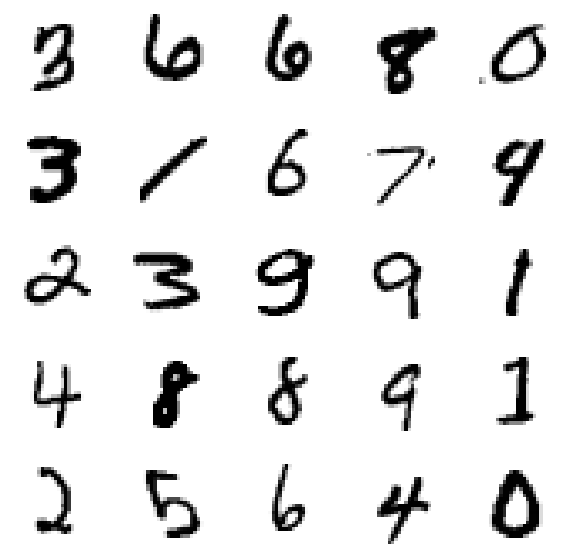

In [44]:
plot(X)

In [45]:
mean = np.average(X, axis=0)
X = X - mean

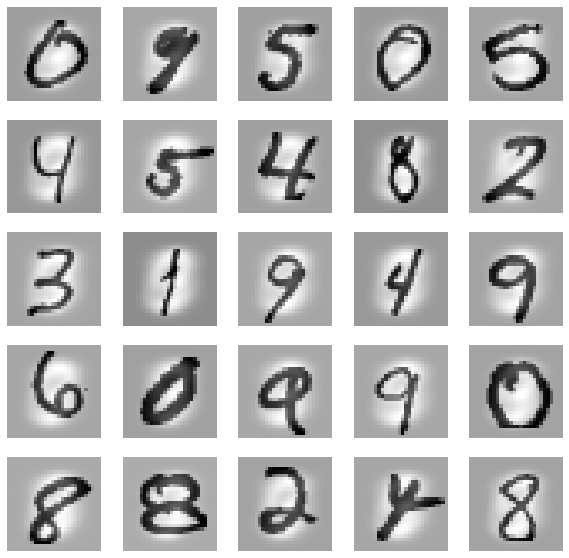

In [46]:
plot(X)

In [47]:
U, s, V =  np.linalg.svd(X, full_matrices=False)

In [48]:
U.shape

(70000, 784)

In [49]:
s.shape

(784,)

In [50]:
V.shape

(784, 784)

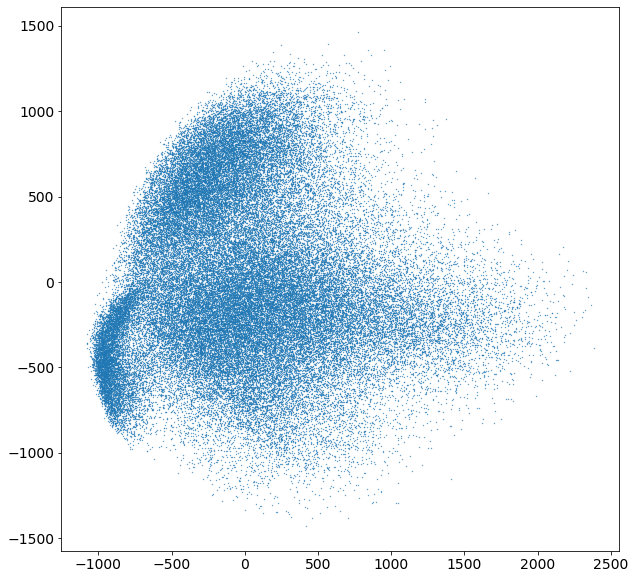

In [51]:
plt_data = plt.scatter((U*s)[:, 0], (U*s)[:, 1], s=0.1)

In [56]:
n = 50
X_rec = (U * s)[:, 0:n] @ V[0:n]

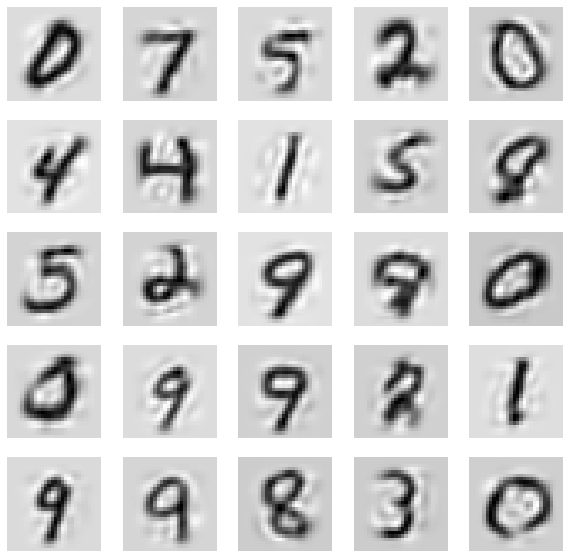

In [57]:
plot(X_rec + mean)

## Using sklearn

There are impementations of PCA available, here we'll use the functionality provided by `sklearn`

In [58]:
from sklearn.decomposition import PCA
p = PCA(n_components=20)
p.fit_transform(X)

array([[ 122.25525502, -316.23383245,  -51.13182136, ...,  294.11575753,
         273.11699857,  151.39187429],
       [1010.49400272, -289.96362194,  576.12074896, ...,   38.21562696,
          64.37791878, -112.61833832],
       [ -58.99594756,  393.69744925, -161.99817496, ..., -120.20137667,
         -20.83856945, -430.70440381],
       ...,
       [-271.50701325,  590.07850144,  341.36885708, ...,   38.87381353,
          80.89875324,  -70.84676449],
       [-310.22482206, -116.72713764,  635.72002933, ...,   92.7357167 ,
        -284.63747536, -211.54881026],
       [1058.86212437,  -83.39254691,  731.3421674 , ..., -310.49291045,
          -5.90382646,  163.6936943 ]])

A good measure of how much detail of the original sample is preserved is the "explained variance". here we see that it is arounf 65-70% using only 20 dimensions to reduce our 784d data!

Text(0.5, 0, 'PCA component')

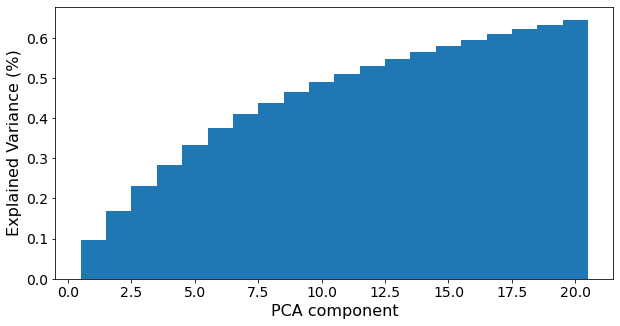

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(np.arange(p.n_components)+1, np.cumsum(p.explained_variance_ratio_), width=1, label='cumulative')

ax.set_ylabel('Explained Variance (%)')
ax.set_xlabel('PCA component')

We can now use our PCA to apply it to the data, and also recosntrcut it in the original space again. They are quite clearly readable despite only using 20d

In [60]:
reduced_data = p.transform(X)

In [61]:
X_rec = p.inverse_transform(reduced_data)

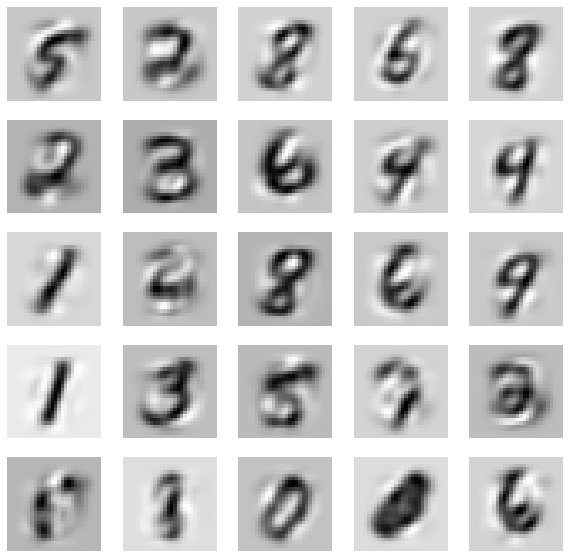

In [62]:
plot(X_rec + mean)

This is how the first two componetns are distributed

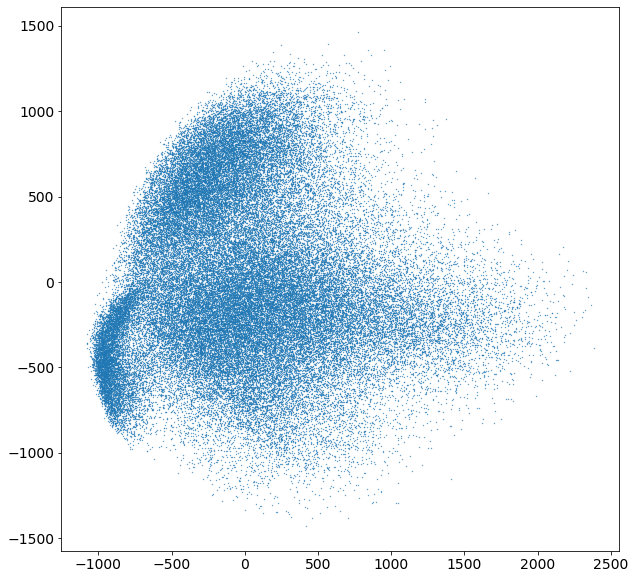

In [63]:
plt_data = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=0.1)

What are these "clusters" of points?

In [64]:
mask = (reduced_data[:, 0] < -700) & (reduced_data[:, 1] < -100)

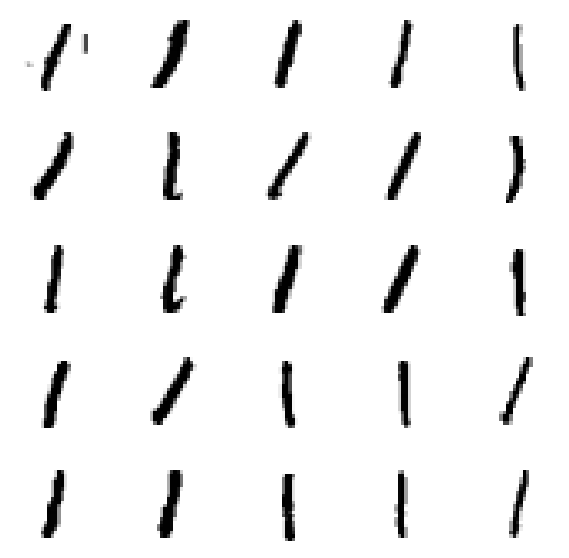

In [65]:
plot((X+mean)[mask])